In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
labels = ["airplane","automobile"	,"bird","cat","deer","dog","frog"	,"horse","ship","truck"]

In [3]:
!pip install np_utils

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, Input, LSTM, concatenate, AveragePooling2D
from tensorflow.keras.layers import Subtract, Conv2D, GlobalMaxPooling2D, Reshape, Conv2DTranspose, UpSampling2D, Embedding
from tensorflow.keras import regularizers
from keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

from matplotlib import pyplot as plt

import numpy as np

Using TensorFlow backend.


In [0]:
#parameters
epsilon = 0.01  #the quantity of perturbation we add to the images
step_pgd = 20   #the number of steps taken during the PGD algo
eta = 0.005     #used in PGD algo


#parameters

epsilon_l2 = 0.4  #the quantity of perturbation we add to the images norm L2
epsilon_inf = 0.031 #norm infini

step_pgd = 20   #the number of steps taken during the PGD algo
eta_l2 = 0.4     #used in PGD algo
eta_inf = 0.031

(Valeurs communément acceptées) Si input est dans [0, 1], alors epsilon doit être à 

0.031 max pour la norme infinie

0.4 max pour la norme 2 (pour que ce soit invisible)

Il n'y a pas de consciensus pour l'utilisation de la norme infinie ou 2 

# Data

In [5]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 4s 0us/step


In [0]:
x_train = x_train / 255
x_test = x_test / 255

y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Network

In [0]:
# (Conv + ReLU + MaxPool)x3 + AvgPool + FC + ReLU + FC (fully connected)
input = tf.keras.Input(shape=(32, 32, 3))
x = Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(input)
x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_last')(x) 

x = Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(input)
x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_last')(x)

x = Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(input)
x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_last')(x)

x = AveragePooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dense(10, activation='softmax')(x)


adversarial = keras.models.Model(inputs=input, outputs=x)
adversarial.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [8]:
history = adversarial.fit(x_train, y_train, batch_size=64, epochs=20, validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 6s 158us/sample - loss: 1.7028 - accuracy: 0.3875 - val_loss: 1.5018 - val_accuracy: 0.4573
Epoch 2/20
40000/40000 [==============================] - 3s 65us/sample - loss: 1.3952 - accuracy: 0.5040 - val_loss: 1.3613 - val_accuracy: 0.5204
Epoch 3/20
40000/40000 [==============================] - 3s 65us/sample - loss: 1.2950 - accuracy: 0.5452 - val_loss: 1.2960 - val_accuracy: 0.5468
Epoch 4/20
40000/40000 [==============================] - 3s 64us/sample - loss: 1.2306 - accuracy: 0.5705 - val_loss: 1.2364 - val_accuracy: 0.5740
Epoch 5/20
40000/40000 [==============================] - 3s 64us/sample - loss: 1.1751 - accuracy: 0.5926 - val_loss: 1.1974 - val_accuracy: 0.5883
Epoch 6/20
40000/40000 [==============================] - 3s 65us/sample - loss: 1.1363 - accuracy: 0.6059 - val_loss: 1.1717 - val_accuracy: 0.5959
Epoch 7/20
40000/40000 [==============================]

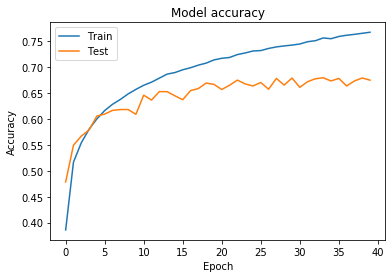

Train accuracy : 0.767625 Test accuracy :  0.6751


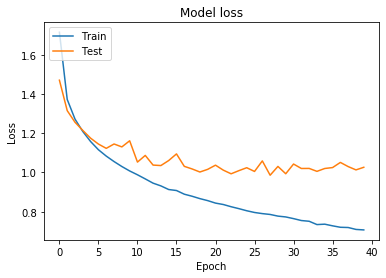

In [0]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
print("Train accuracy :",history.history['accuracy'][39] ,"Test accuracy : ",history.history['val_accuracy'][39])
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Perturbations (FGSM, norme infinie)

In [0]:
#create the perturbations
#the perturbations are on the test set
image = tf.cast(x_test, tf.float32)
    
with tf.GradientTape() as tape:
  tape.watch(image)
  prediction = adversarial(image)
  loss = tf.keras.losses.MSE(y_test, prediction)
    
gradient = tape.gradient(loss, image)
    
perturbations_inf = tf.sign(gradient).numpy()*epsilon_inf 

perturbations_l2 = np.zeros((len(x_test),32,32,3))
for i in range(len(x_test)):
  perturbations_l2[i]=(epsilon_l2*gradient[i]/np.linalg.norm(gradient[i])).numpy()

x_test_fgsm = x_test + perturbations_inf
x_test_fgm = x_test + perturbations_l2

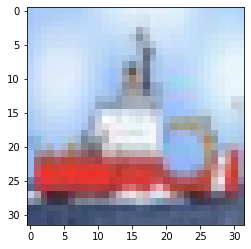

Prediction (Orginal image) :  ship


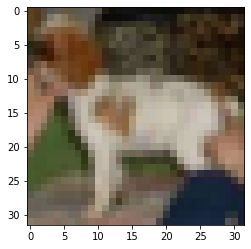

Prediction (Orginal image) :  dog


In [0]:
#the original image
plt.imshow(x_test[92].reshape((32, 32, 3)))
plt.show()
label = (np.argmax(adversarial.predict(np.reshape((x_test[92]),[1,32,32,3]) , batch_size=None, verbose=0, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False)))
print("Prediction (Orginal image) : ", labels[label])

plt.imshow(x_test[12].reshape((32, 32, 3)))
plt.show()
label = (np.argmax(adversarial.predict(np.reshape((x_test[12]),[1,32,32,3]) , batch_size=None, verbose=0, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False)))
print("Prediction (Orginal image) : " ,labels[label])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


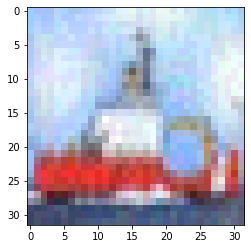

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction (FGSM) :  automobile


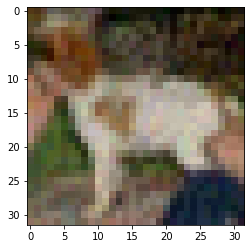

Prediction (FGSM) :  bird


In [0]:
#the modified image (FGSM)
plt.imshow(x_test_fgsm[92].reshape((32, 32, 3)))
plt.show()
label = (np.argmax(adversarial.predict(np.reshape((x_test_fgsm[92]),[1,32,32,3]) , batch_size=None, verbose=0, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False)))
print("Prediction (FGSM) : ", labels[label])

plt.imshow(x_test_fgsm[12].reshape((32, 32, 3)))
plt.show()
label = (np.argmax(adversarial.predict(np.reshape((x_test_fgsm[12]),[1,32,32,3]) , batch_size=None, verbose=0, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False)))
print("Prediction (FGSM) : ", labels[label])

In [0]:
#results for the original image
print(adversarial.evaluate(x_test, y_test))

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [0]:
#results for the modified image
print(adversarial.evaluate(x_test_fgsm, y_test))
print(adversarial.evaluate(x_test_fgm, y_test))

NameError: ignored

In [0]:
#create the perturbations for TRAINING SET
image = tf.cast(x_train[:10000,:,:,:], tf.float32)
    
with tf.GradientTape() as tape:
  tape.watch(image)
  prediction = adversarial(image)
  loss = tf.keras.losses.MSE(y_train[:10000], prediction)
    
gradient = tape.gradient(loss, image)
    
perturbations_inf = tf.sign(gradient).numpy()*epsilon_inf 

perturbations_l2 = np.zeros((10000,32,32,3))
for i in range(10000):
  perturbations_l2[i]=(epsilon_l2*gradient[i]/np.linalg.norm(gradient[i])).numpy()

x_train_fgsm = x_train[:10000] + perturbations_inf
x_train_fgm = x_train[:10000]  + perturbations_l2

In [0]:
print(adversarial.evaluate(x_train_fgsm, y_test))
print(adversarial.evaluate(x_train_fgm, y_test))

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================



# Perturbations (PGD, norme infinie)

In [0]:

#create the perturbations

#Norme infinie 

x_test_pgd_inf = np.copy(x_test)
x_train_pgd_inf = np.copy(x_train[:10000,:,:,:])
image_ref = tf.cast(x_test, tf.float32)
image_ref_train = tf.cast(x_train[:10000,:,:,:], tf.float32)
    
for step in range(step_pgd):
  image = tf.cast(x_test_pgd_inf, tf.float32)
  image_train =  tf.cast(x_train_pgd_inf, tf.float32)
  with tf.GradientTape() as tape:
    tape.watch(image)
    #tape.watch(image_train)
    prediction = adversarial(image)
    #prediction = adversarial(image_train)
    loss = tf.keras.losses.MSE(y_test, prediction)
    #loss = tf.keras.losses.MSE(y_train[:10000], prediction)

      
  gradient = tape.gradient(loss, image)
  
  perturbations_inf = tf.sign(gradient).numpy()*eta_inf
  x_test_pgd_inf = x_test_pgd_inf + perturbations_inf
  x_train_pgd_inf = x_train_pgd_inf + perturbations_inf  
  x_test_pgd_inf = np.maximum(np.minimum(x_test_pgd_inf, x_test + epsilon), x_test - epsilon)
  x_train_pgd_inf = np.maximum(np.minimum(x_train_pgd_inf, x_test + epsilon), x_train[:10000,:,:,:] - epsilon)

In [0]:
#Norme L2

x_test_pgd_l2 = np.copy(x_test)
image_ref = tf.cast(x_test, tf.float32)

for step in range(step_pgd):
  image = tf.cast(x_test_pgd_l2, tf.float32)
  with tf.GradientTape() as tape:
    tape.watch(image)
    prediction = adversarial(image)
    loss = tf.keras.losses.MSE(y_test, prediction)
  
  gradient = tape.gradient(loss,image)

  perturbations_l2 = np.zeros((len(x_test),32,32,3))
  for i in range(len(x_test_pgd_l2)):
    perturbations_l2[i]=(eta_l2*gradient[i]/np.linalg.norm(gradient[i])).numpy()

  x_test_pgd_l2 = x_test_pgd_l2 + perturbations_l2
  x_test_pgd_l2 = np.maximum(np.minimum(x_test_pgd_l2,x_test + epsilon),x_test - epsilon)

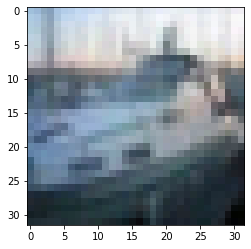

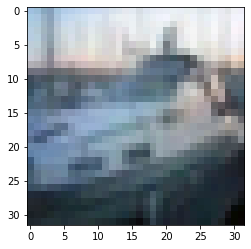

In [0]:
#the modified image (PGD)

#Norme Inf
plt.imshow(x_test_pgd_inf[2].reshape((32, 32, 3)))
plt.show()

#Norme L2
plt.imshow(x_test_pgd_l2[2].reshape((32, 32, 3)))
plt.show()

In [0]:

#Norme Inf 
print(adversarial.evaluate(x_test_pgd_inf, y_test))

#Norme L2 
print(adversarial.evaluate(x_test_pgd_l2, y_test))

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [0]:
#create the perturbations
#the perturbations are on the test set
def process_fgsm(eps):
  image = tf.cast(x_test, tf.float32)
      
  with tf.GradientTape() as tape:
    tape.watch(image)
    prediction = adversarial(image)
    loss = tf.keras.losses.MSE(y_test, prediction)
      
  gradient = tape.gradient(loss, image)
      
  perturbations = tf.sign(gradient).numpy()
  print(type(perturbations))
  print(perturbations.shape)

  x_test_fgsm = x_test + perturbations * eps
  return(x_test_fgsm)

In [0]:
eps_grid = [0.0001,0.001,0.01,0.031,0.05, 0.1]
eps_g = [0.01,0.031,0.05, 0.1]

<class 'numpy.ndarray'>
(10000, 32, 32, 3)


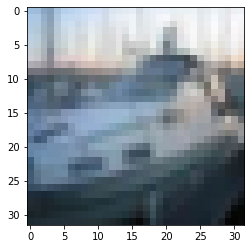

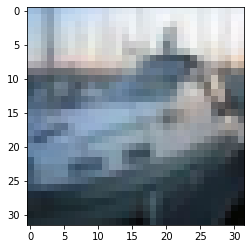

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

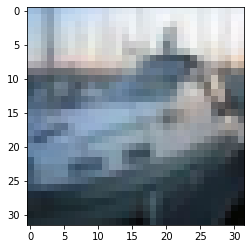

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

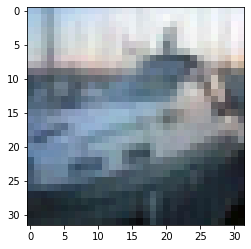

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'numpy.ndarray'>
(10000, 32, 32, 3)


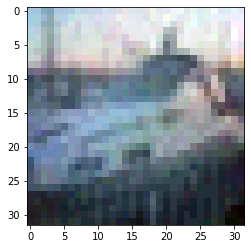

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'numpy.ndarray'>
(10000, 32, 32, 3)


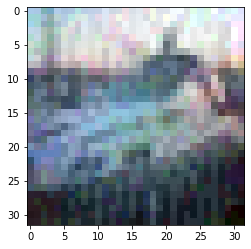

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'numpy.ndarray'>
(10000, 32, 32, 3)


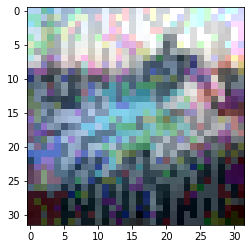

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

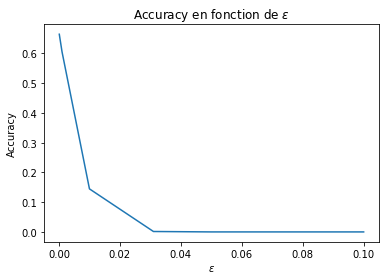

In [0]:
acc = []
plt.imshow(x_test[2].reshape((32, 32, 3)))
for eps in eps_grid :
  x = process_fgsm(eps)
  plt.show()
  plt.imshow(x[2].reshape((32, 32, 3)))
  plt.show()
  acc.append(adversarial.evaluate(x, y_test)[1])
print(acc)

plt.title('Accuracy en fonction de $\epsilon$')
plt.xlabel('$\epsilon$')
plt.ylabel('Accuracy')
plt.plot(eps_grid,acc)
plt.show()


# Adversarial training

In [0]:
# (Conv + ReLU + MaxPool)x3 + AvgPool + FC + ReLU + FC (fully connected)
input = tf.keras.Input(shape=(32, 32, 3))
x = Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(input)
x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_last')(x) 

x = Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(input)
x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_last')(x)

x = Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(input)
x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_last')(x)

x = AveragePooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dense(10, activation='softmax')(x)

adversarial_trained = keras.models.Model(inputs=input, outputs=x)
adversarial_trained.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
#boucle
epochs = 7
x_train_adv = np.copy(x_train[:3500, :, :, :])
y_train_adv = np.copy(y_train[:3500])
histories = [0 for i in range(epochs)]
#training with the modified training set 
for i in range (epochs):
    histories[i] = adversarial_trained.fit(x_train_adv, y_train_adv, batch_size=64, epochs=1, validation_split=0.2)

    image = tf.cast(x_train_adv, tf.float32)

    with tf.GradientTape() as tape:
      tape.watch(image)
      prediction = adversarial_trained(image)
      loss = tf.keras.losses.MSE(y_train_adv, prediction)

      gradient = tape.gradient(loss, image)
    #tf.enable_eager_execution()
    print(tf.executing_eagerly())
    perturbations = tf.sign(gradient).numpy()
    x_train_adv = np.append(x_train_adv,x_train_adv[i*3500:, :, :, :] + perturbations[i*3500:,:,:,:] * epsilon,axis=0)
    print(x_train_adv.shape)
    y_train_adv = np.append(y_train_adv,y_train[:3500],axis=0)
    print(y_train_adv.shape)

Train on 2800 samples, validate on 700 samples
2800/2800 [==============================] - 2s 782us/sample - loss: 2.1652 - accuracy: 0.2036 - val_loss: 2.0208 - val_accuracy: 0.2786
True
(7000, 32, 32, 3)
(7000, 10)
Train on 5600 samples, validate on 1400 samples
5600/5600 [==============================] - 2s 325us/sample - loss: 1.9571 - accuracy: 0.2884 - val_loss: 1.9453 - val_accuracy: 0.3000
True
(10500, 32, 32, 3)
(10500, 10)
Train on 8400 samples, validate on 2100 samples
8400/8400 [==============================] - 3s 330us/sample - loss: 1.8155 - accuracy: 0.3498 - val_loss: 1.9411 - val_accuracy: 0.2905
True
(14000, 32, 32, 3)
(14000, 10)
Train on 11200 samples, validate on 2800 samples
11200/11200 [==============================] - 4s 334us/sample - loss: 1.6870 - accuracy: 0.3969 - val_loss: 1.9375 - val_accuracy: 0.2782
True
(17500, 32, 32, 3)
(17500, 10)
Train on 14000 samples, validate on 3500 samples
14000/14000 [==============================] - 5s 323us/sample - lo

In [0]:
#results for the original image
print(adversarial_trained.evaluate(x_test, y_test))
print(adversarial_trained.evaluate(x_test_fgsm, y_test))

NameError: ignored

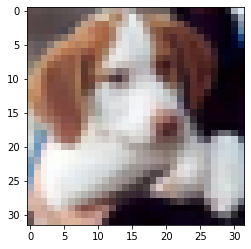

[[0.    0.    0.018 0.077 0.    0.883 0.009 0.011 0.    0.   ]]
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [191]:
plt.imshow(x_test[16].reshape((32,32,3)))
plt.show()
print(np.around(adversarial.predict(np.reshape(x_test[16],[1,32,32,3]), batch_size=None, verbose=0, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False), decimals=3))
print(labels)

In [0]:
def NES_grad(sigma, n_sample = x_train.shape[0],n=[32,32,3]):
  g = np.zeros([n_sample,32,32,3])
  for i in range(n_sample):
    u = np.random.normal(0,1,n)
    g[i] = g + np.argmax(adversarial.predict(np.reshape(x_train[i] + sigma*u,[1,32,32,3]) , batch_size=None, verbose=0, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False),axis=1)*u
    g[i] = g- np.argmax(adversarial.predict(np.reshape(x_train[i] - sigma*u,[1,32,32,3]), batch_size=None, verbose=0, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False),axis=1)*u
  return(1/(2*n_sample*sigma)*g)
    

NameError: ignored

In [0]:
def gen_perturbations_show(img,label,eps,maxpert):
  fiximg = img
  plt.imshow(img.reshape((32,32,3)))
  plt.show()
  pred = np.argmax(adversarial.predict(np.reshape(img,[1,32,32,3]), batch_size=None, verbose=0, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False),axis =1 )[0]
  print(labels[pred])
  score = 1
  scores = []
  while (pred == np.argmax(label)) :
    #rand_pert = np.random.randint(-1,2,size=[32,32,3])*eps
    rand_pert = np.random.normal(0,1,size=[32,32,3])*eps
    new_img = img + rand_pert
    tablepred  = adversarial.predict(new_img, batch_size=None, verbose=0, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False)
    pred = np.argmax(tablepred,axis =1 )[0]
    if (tablepred[0][pred]<score) :
      img = new_img
      score = tablepred[0][pred]
      scores.append(score)
    pertsize = np.linalg.norm(fiximg-new_img)
    if (pertsize>maxpert):
      print('ON SELOIGNE TROP')
      return('Pas trouvé')
  if (score!=1):
    print(labels[np.argmax(adversarial.predict(new_img, batch_size=None, verbose=0, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False),axis =1 )[0]])
    plt.imshow(new_img.reshape((32,32,3)))
  else : 
    print(labels[np.argmax(adversarial.predict(img, batch_size=None, verbose=0, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False),axis =1 )[0]])
    plt.imshow(img.reshape((32,32,3)))
  plt.show()
  return(new_img,scores,pertsize)

In [0]:
def gen_perturbations_process(img,label,eps,maxpert):
  fiximg = img
  pred = np.argmax(adversarial.predict(np.reshape(img,[1,32,32,3]), batch_size=None, verbose=0, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False),axis =1 )[0]
  score = 1
  scores = []
  while (pred == np.argmax(label)) :
    rand_pert = np.random.normal(0,1,size=[32,32,3])*eps
    new_img = img + rand_pert
    tablepred  = adversarial.predict(new_img, batch_size=None, verbose=0, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False)
    pred = np.argmax(tablepred,axis =1 )[0]
    if (tablepred[0][pred]<score) :
      img = new_img
      score = tablepred[0][pred]
      scores.append(score)
    pertsize = np.linalg.norm(fiximg-new_img)
    if (pertsize>maxpert):
      print('ON SELOIGNE TROP')
      return(img,scores,0)
  if (score==1):
    return(img,scores,0)
  return(new_img,scores,pertsize)

In [0]:
import time

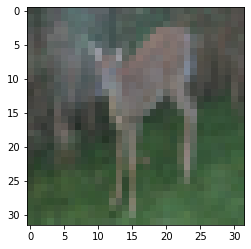

deer
horse


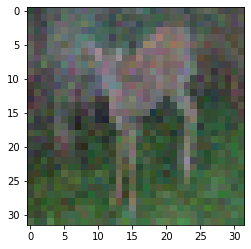

2.9779412746429443


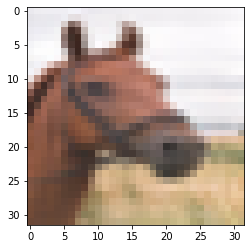

horse


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


bird


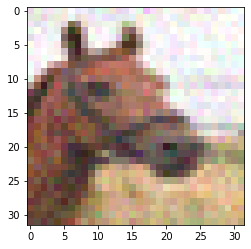

5.917097330093384


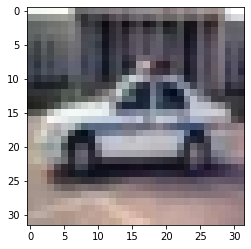

automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


truck


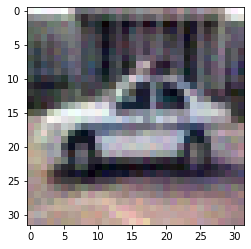

7.325758695602417


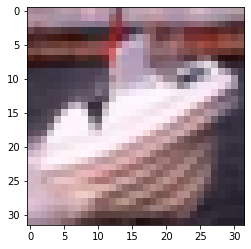

ship


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


cat


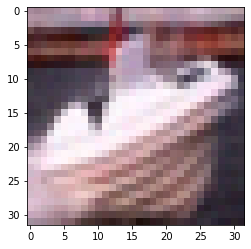

7.688196659088135


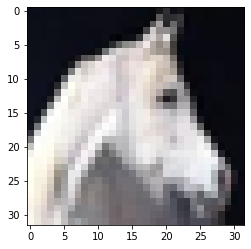

horse


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


dog


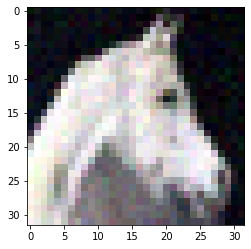

9.992861986160278


In [196]:
t = time.time()
tot = 0
idxcool = [0,5,10,14,15]
#for i in range(20):
for i in idxcool:
  gen_perturbations_show(np.reshape(x_test[94+i,:,:,:],[1,32,32,3]),y_test[94+i],0.005,3)
  print(time.time()-t)




In [197]:
t = time.time()
tot = 0
x_pert = np.zeros((1000,32,32,3))
for i in range(1000):
  x_pert[i]= gen_perturbations_process(np.reshape(x_test[i,:,:,:],[1,32,32,3]),y_test[i],0.005,3)[0]
  print(time.time()-t)
  


1.5813977718353271
2.0886175632476807
2.107999563217163
3.0056710243225098
4.047598838806152
10.130083322525024
14.342530012130737
17.170910835266113
18.998723030090332
ON SELOIGNE TROP
23.56751561164856
23.587483167648315
28.523008108139038
29.568127632141113
ON SELOIGNE TROP
34.12670826911926
38.50704002380371
38.527642011642456
ON SELOIGNE TROP
42.965819358825684
43.20892834663391
ON SELOIGNE TROP
47.16809844970703
ON SELOIGNE TROP
52.47808766365051
52.74835276603699
53.06659460067749
53.084699869155884
54.88310122489929
54.90147256851196
54.919554710388184
57.41851353645325
57.43790340423584
59.43029713630676
ON SELOIGNE TROP
66.24242925643921
69.63317799568176
69.65142369270325
71.69012689590454
72.91775107383728
74.07216835021973
74.09411239624023
77.21533155441284
77.23880553245544
ON SELOIGNE TROP
82.08064937591553
ON SELOIGNE TROP
85.92301988601685
85.94084882736206
ON SELOIGNE TROP
92.04771137237549
93.96114158630371
ON SELOIGNE TROP
100.57707929611206
101.79701566696167
ON S

In [200]:
print(adversarial.evaluate(np.reshape(x_pert,[1000,32,32,3]), y_test[:1000]))


1000/1000 [==============================] - 0s 85us/sample - loss: 1.3478 - accuracy: 0.1250
[1.3477889013290405, 0.125]


In [0]:
def pixel(img,label):
  wrong_class = 0
  print(labels[np.argmax(label)])
  plt.imshow(img.reshape((32,32,3)))    
  plt.show()  
  for i in range(32*32):
    pix = np.zeros(32*32)
    pix[i] = 1 
    pix = np.reshape(pix,[1,32,32])
    pert = np.concatenate((pix,pix,pix),axis=0).T
    testpix = img + pert
    tablepred = adversarial.predict(np.reshape(testpix,[1,32,32,3]), batch_size=None, verbose=0, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False) 
    pred = np.argmax(tablepred,axis =1 )[0]
    if(pred!=np.argmax(label)):
      #plt.imshow(testpix.reshape((32,32,3))) 
      #plt.show()     
      #print(labels[pred])
      wrong_class +=1
  return(wrong_class)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


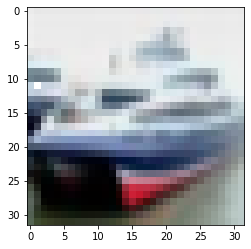

In [171]:
#print(labels[np.argmax(adversarial.predict(img, batch_size=None, verbose=0, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False),axis =1 )[0]])
plt.imshow(testpix.reshape((32,32,3)))      

ship


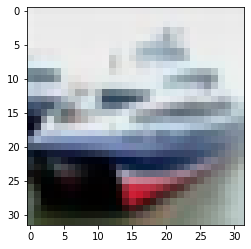

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


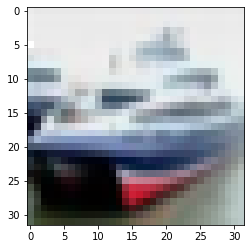

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


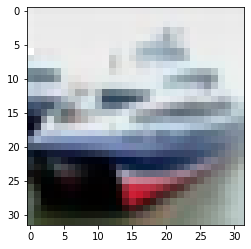

automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


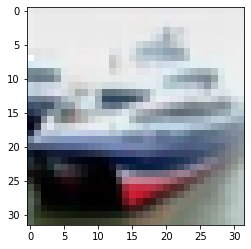

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


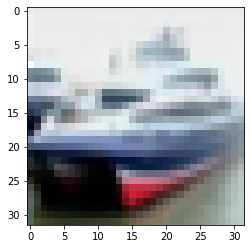

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


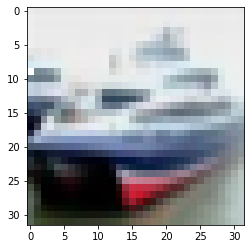

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


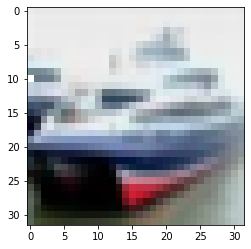

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


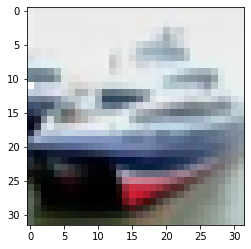

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


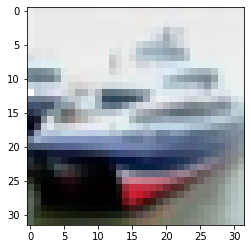

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


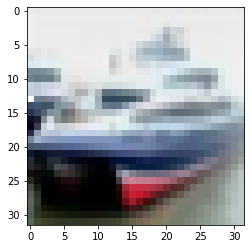

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


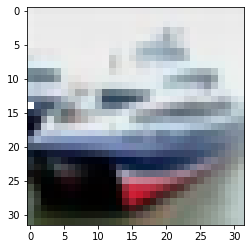

automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


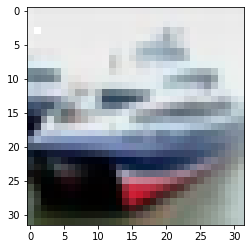

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


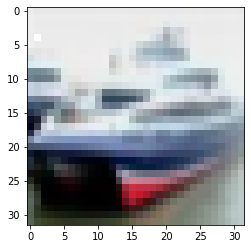

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


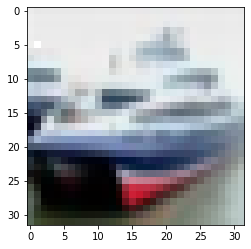

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


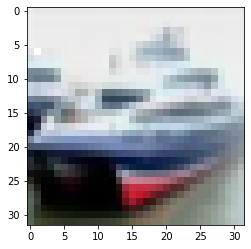

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


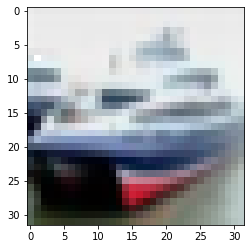

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


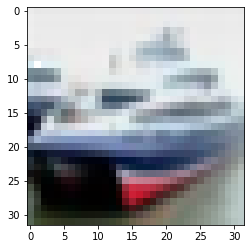

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


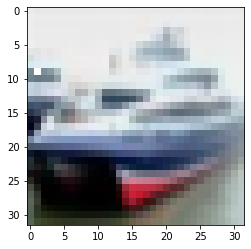

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


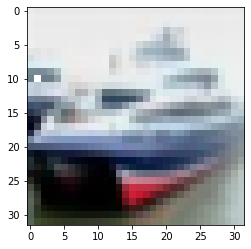

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


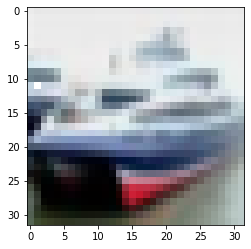

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


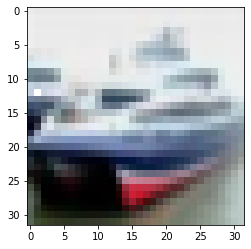

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


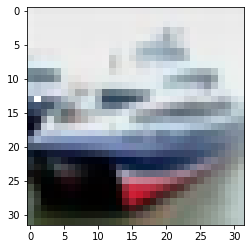

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


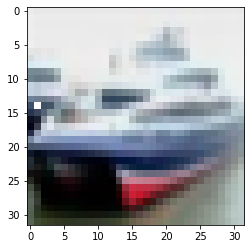

automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


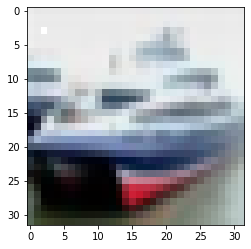

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


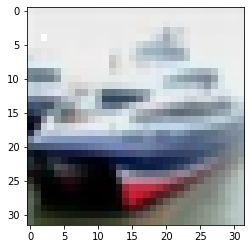

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


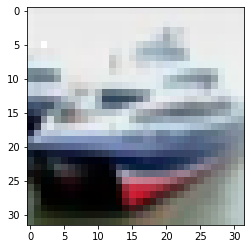

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


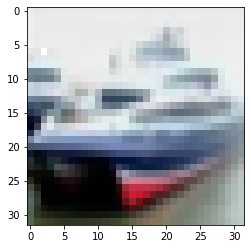

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


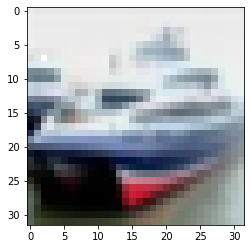

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


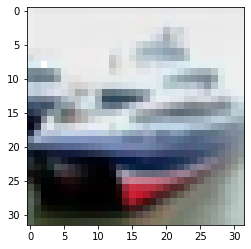

automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


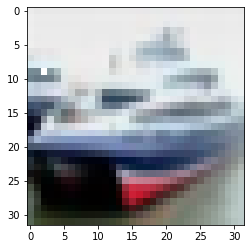

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


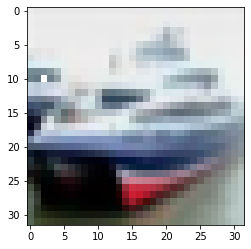

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


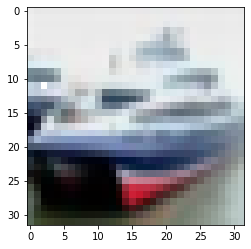

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


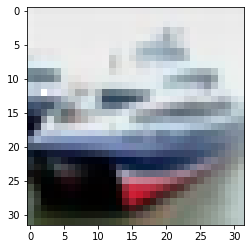

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


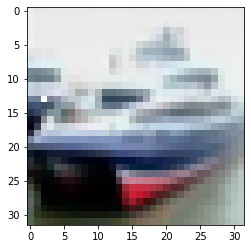

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


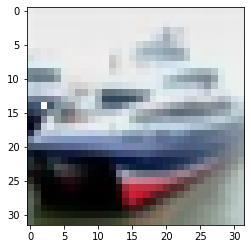

automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


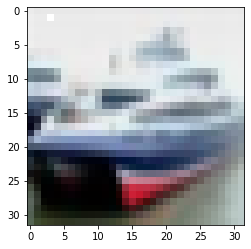

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


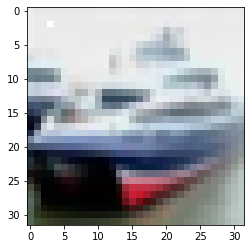

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


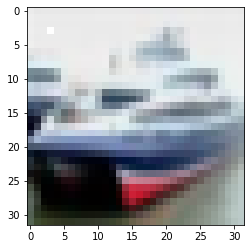

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


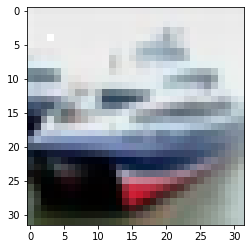

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


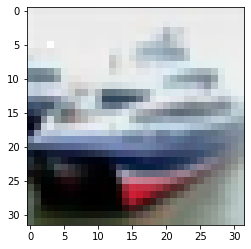

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


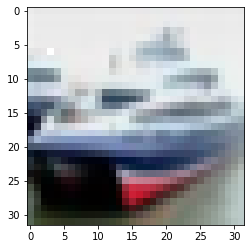

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


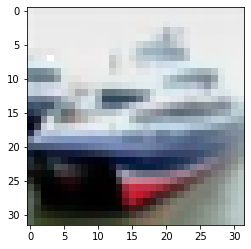

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


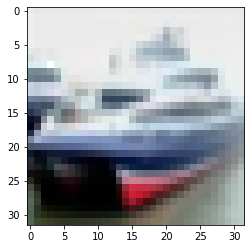

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


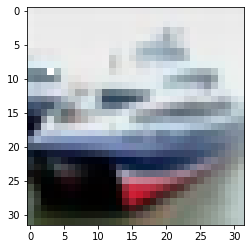

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


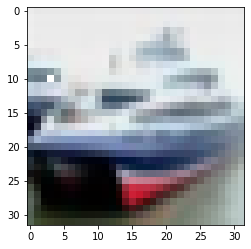

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


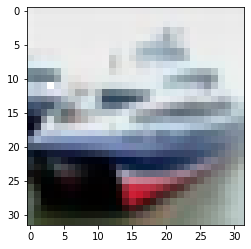

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


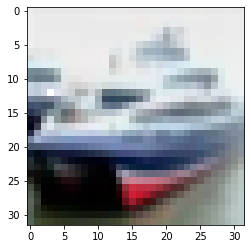

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


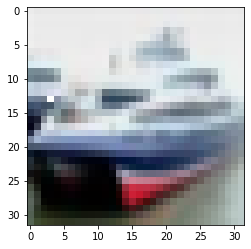

automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


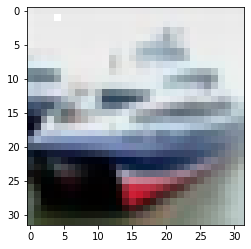

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


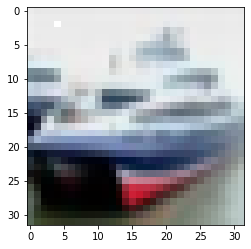

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


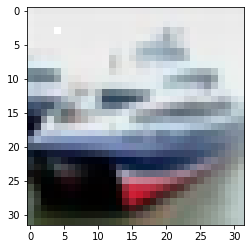

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


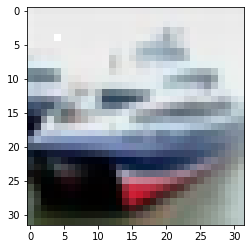

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


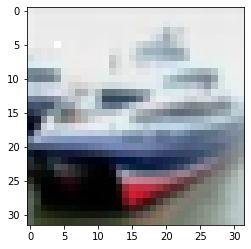

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


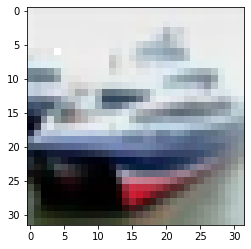

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


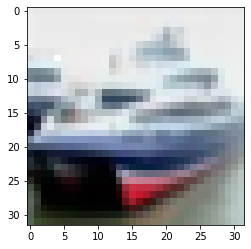

automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


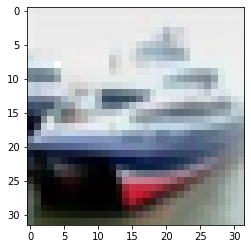

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


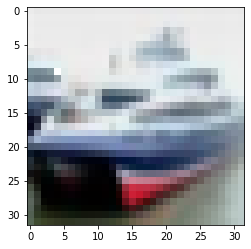

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


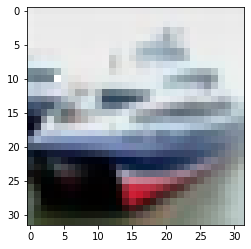

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


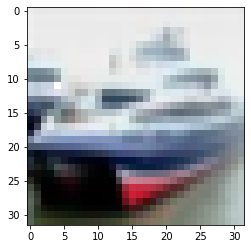

automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


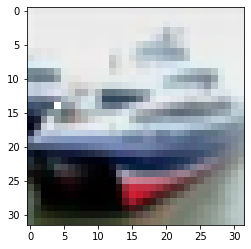

automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


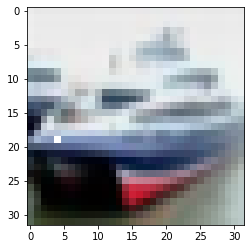

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


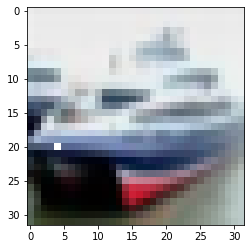

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


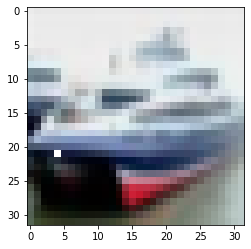

automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


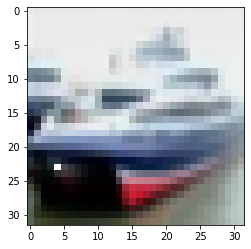

automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


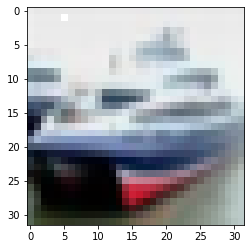

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


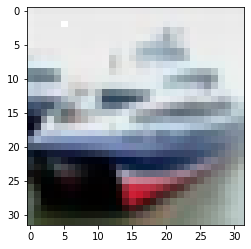

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


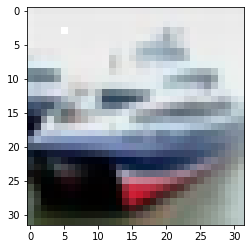

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


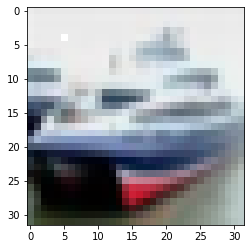

automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


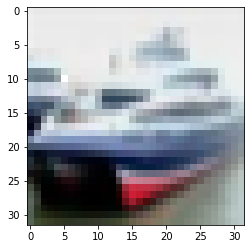

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


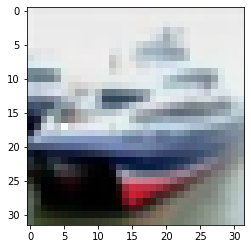

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


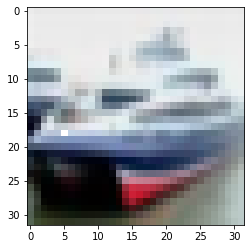

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


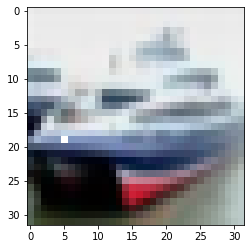

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


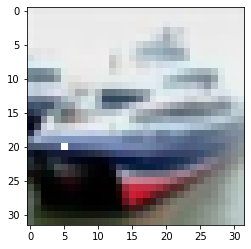

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


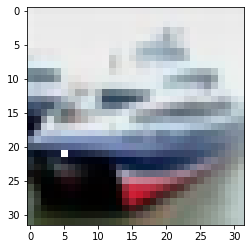

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


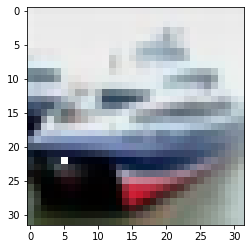

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


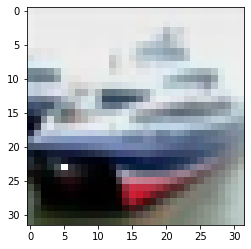

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


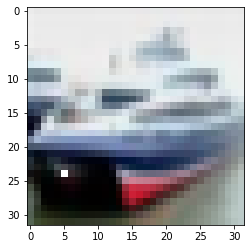

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


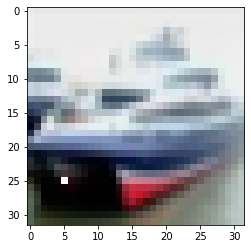

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


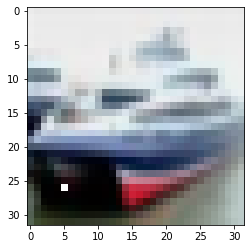

automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


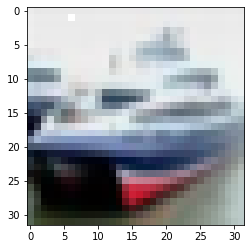

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


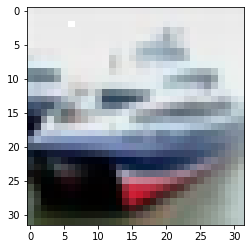

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


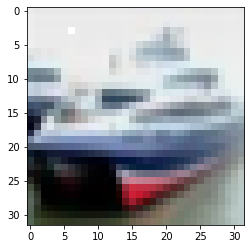

automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


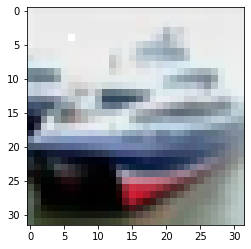

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


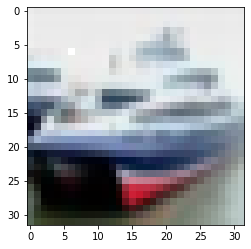

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


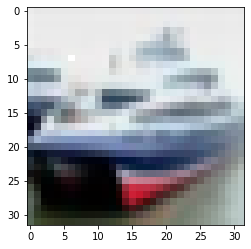

automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


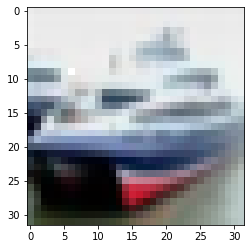

automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


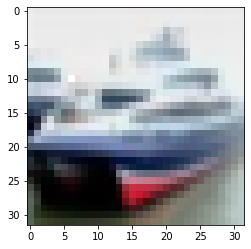

automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


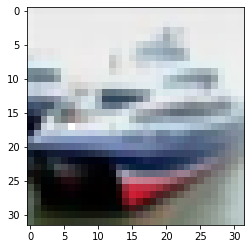

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


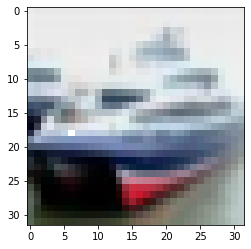

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


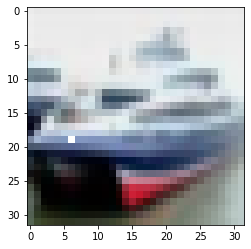

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


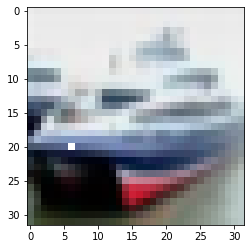

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


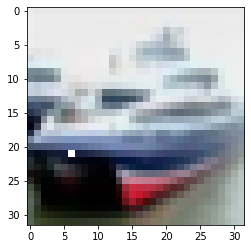

automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


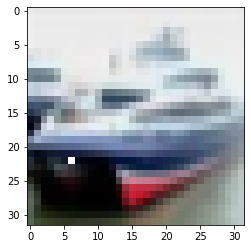

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


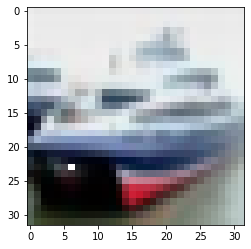

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


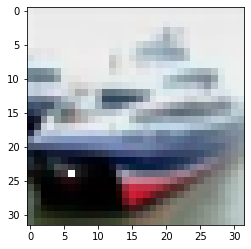

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


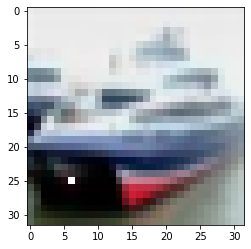

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


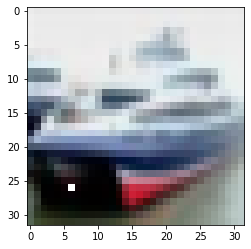

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


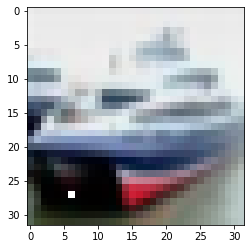

automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


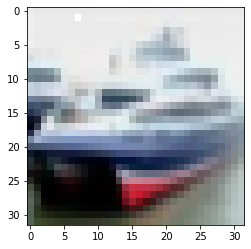

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


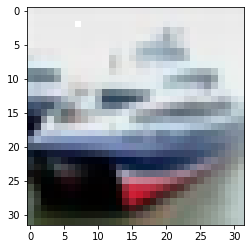

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


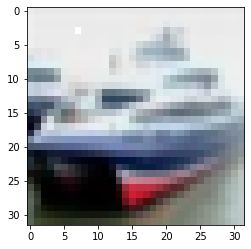

automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


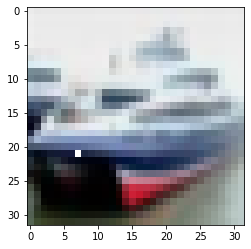

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


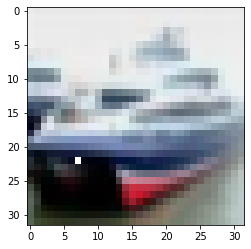

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


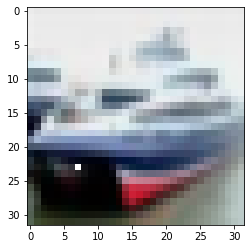

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


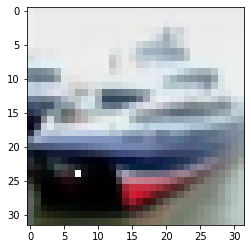

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


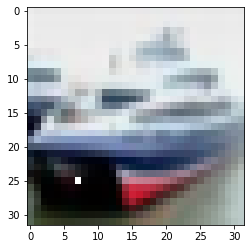

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


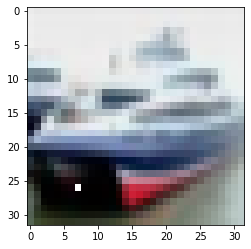

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


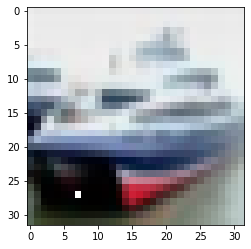

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


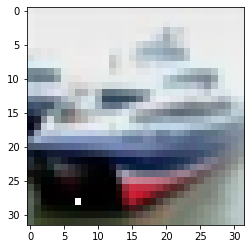

automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


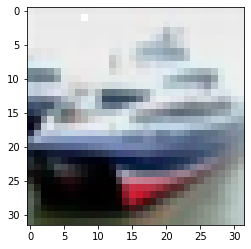

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


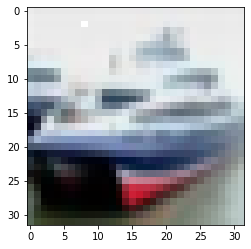

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


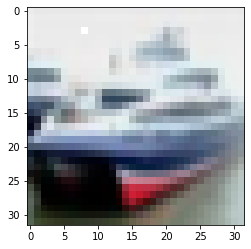

automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


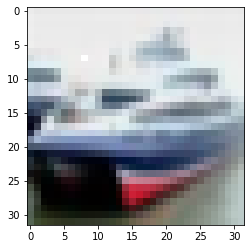

automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


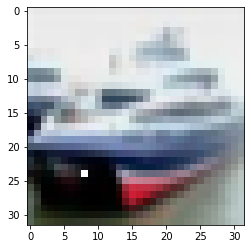

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


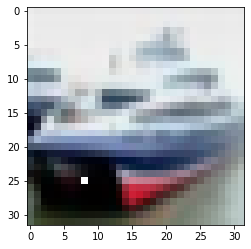

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


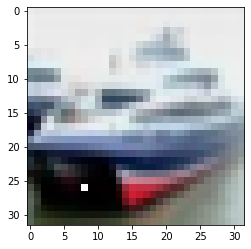

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


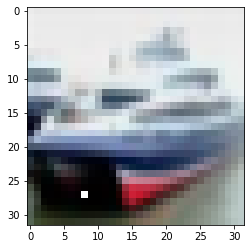

automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


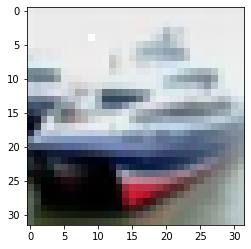

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


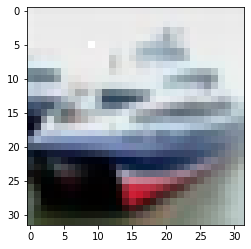

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


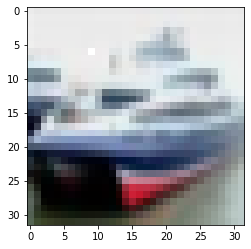

automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


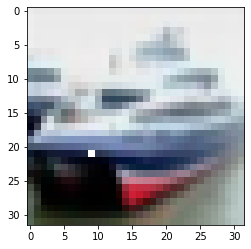

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


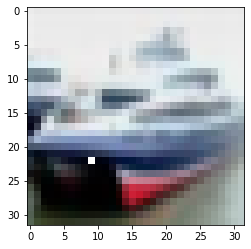

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


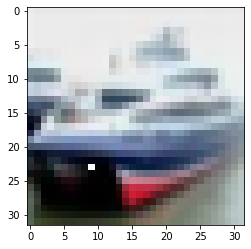

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


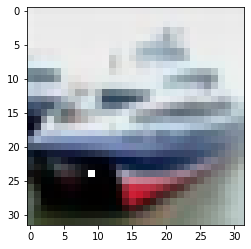

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


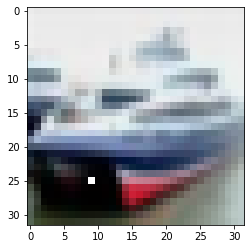

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


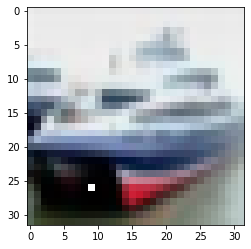

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


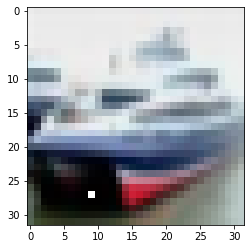

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


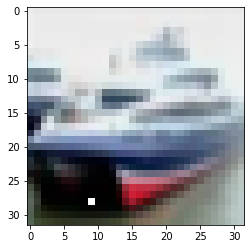

automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


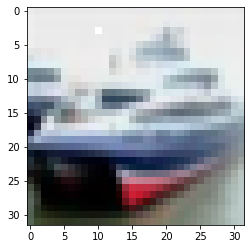

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


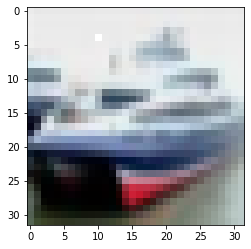

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


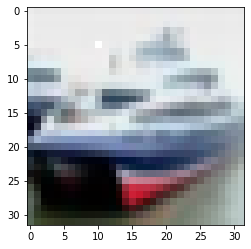

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


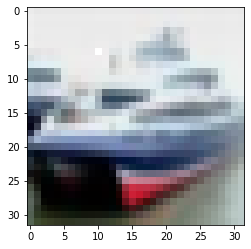

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


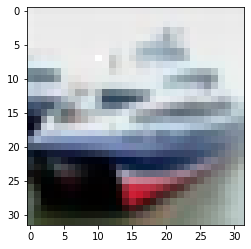

automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


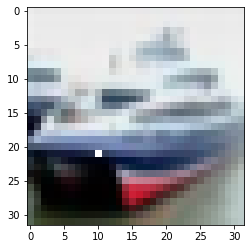

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


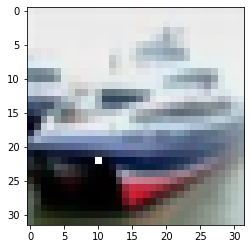

automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


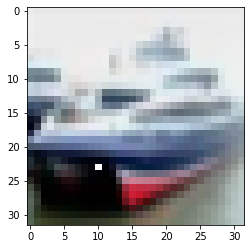

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


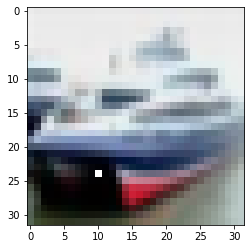

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


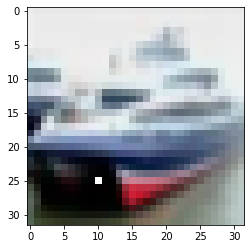

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


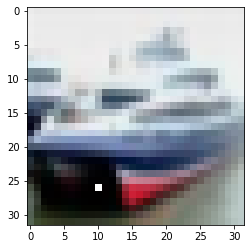

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


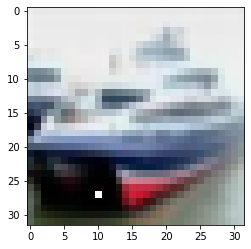

automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


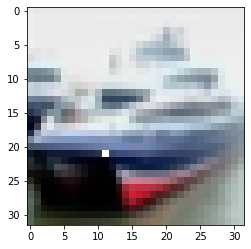

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


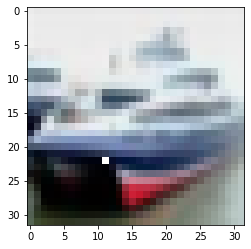

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


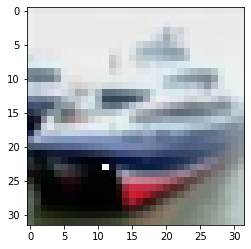

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


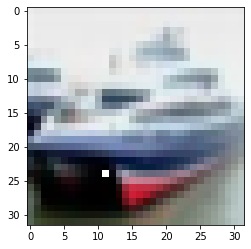

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


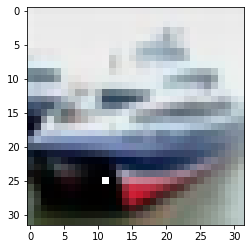

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


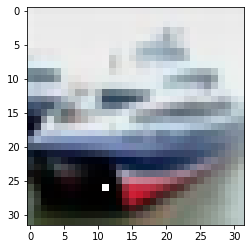

automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


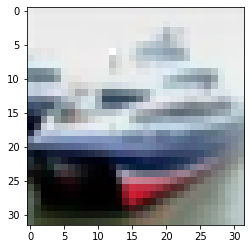

automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


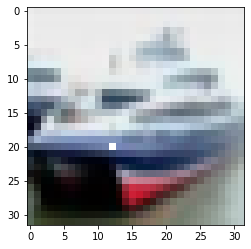

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


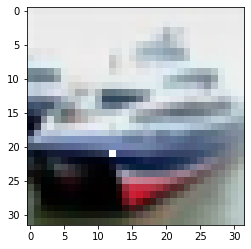

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


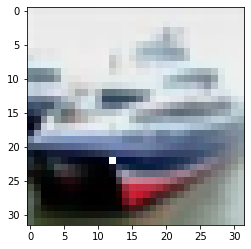

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


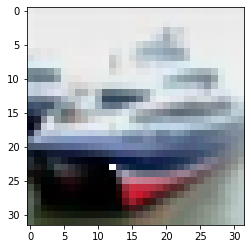

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


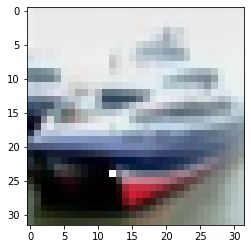

automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


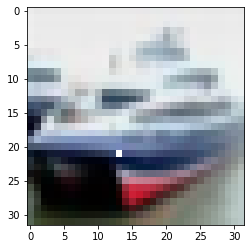

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


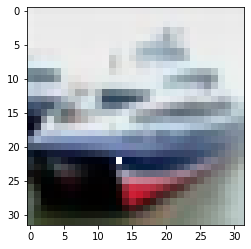

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


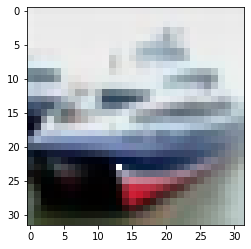

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


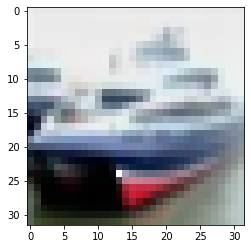

automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


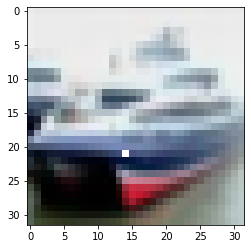

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


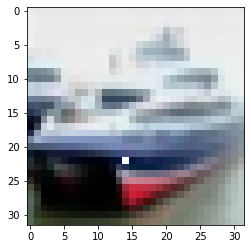

automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


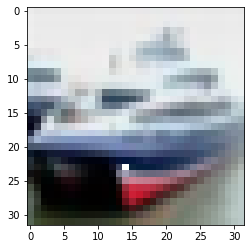

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


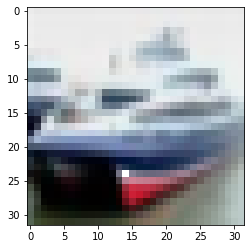

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


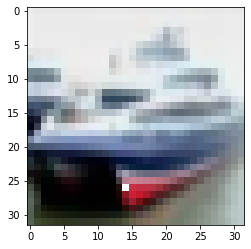

automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


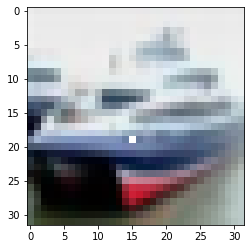

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


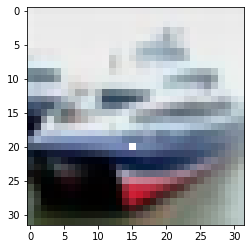

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


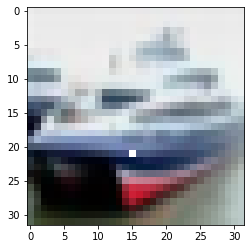

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


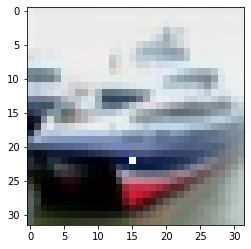

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


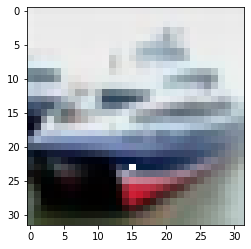

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


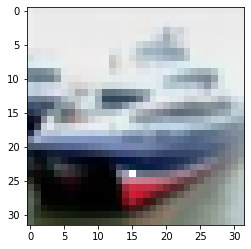

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


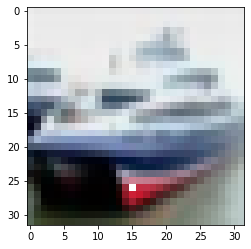

automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


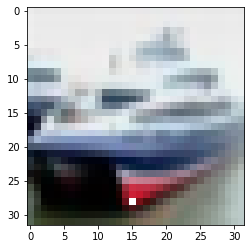

automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


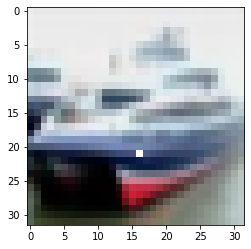

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


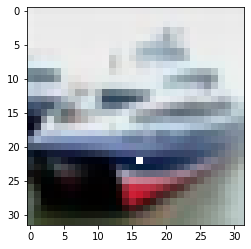

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


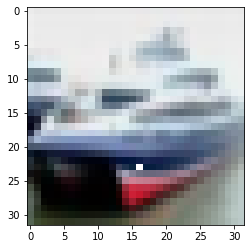

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


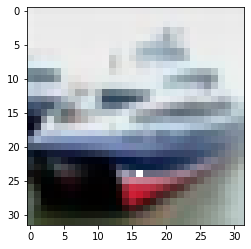

automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


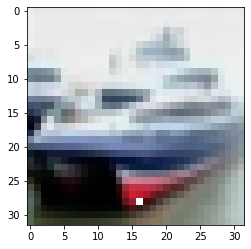

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


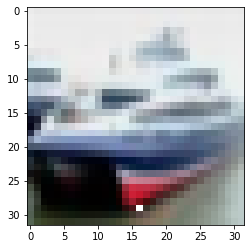

automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


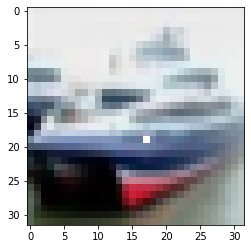

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


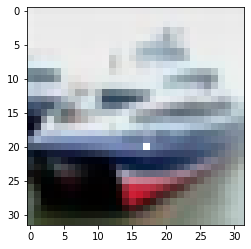

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


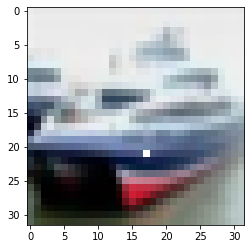

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


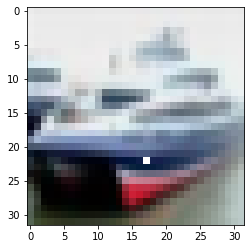

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


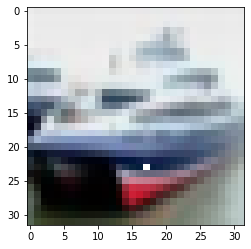

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


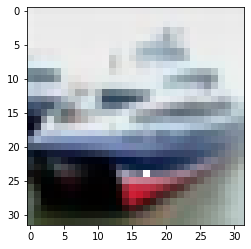

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


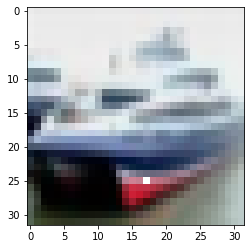

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


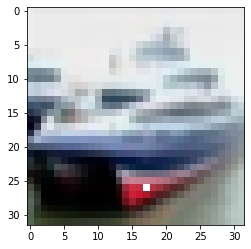

automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


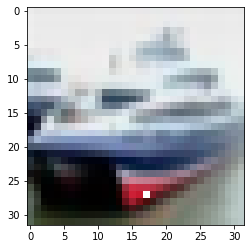

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


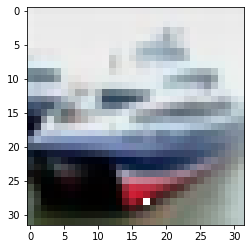

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


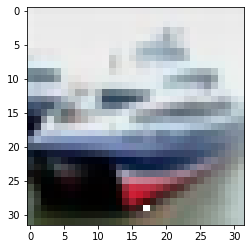

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


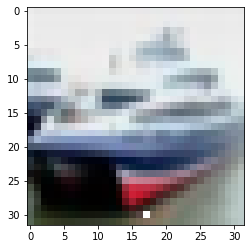

automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


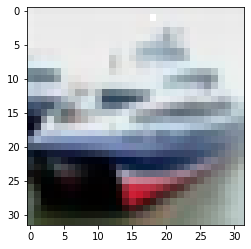

automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


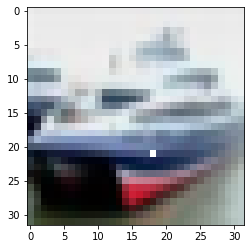

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


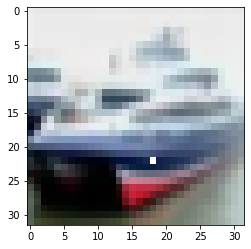

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


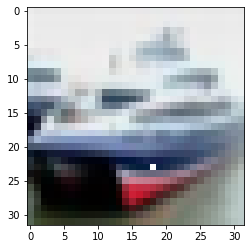

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


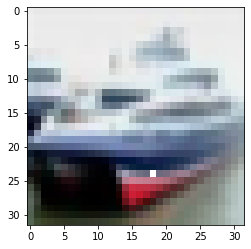

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


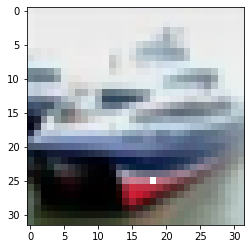

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


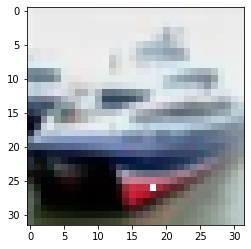

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


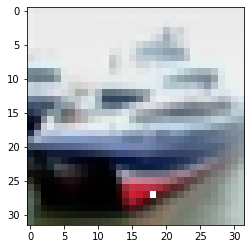

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


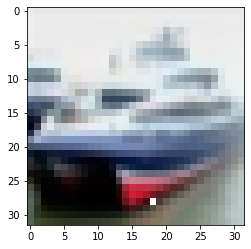

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


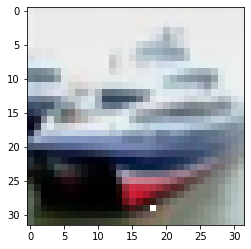

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


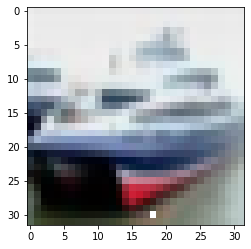

automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


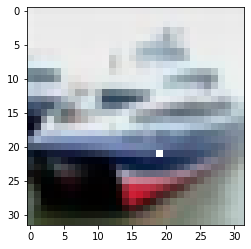

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


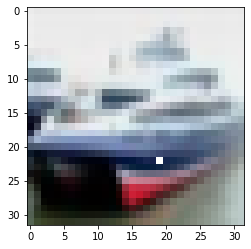

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


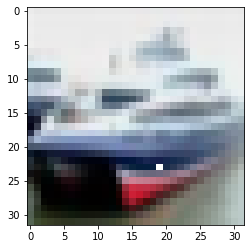

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


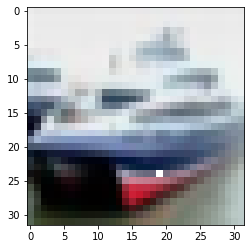

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


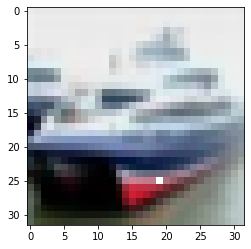

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


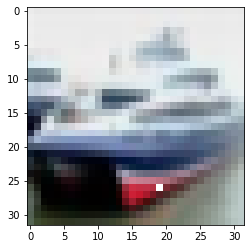

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


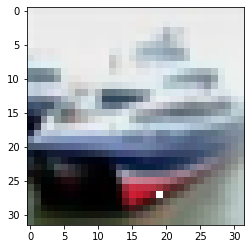

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


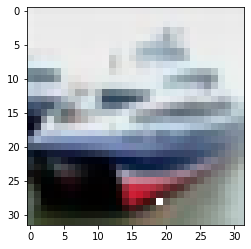

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


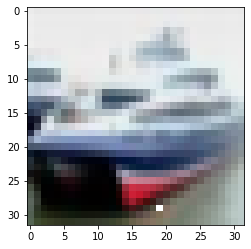

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


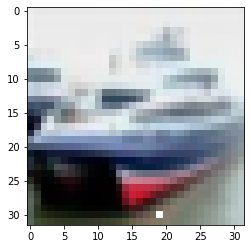

automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


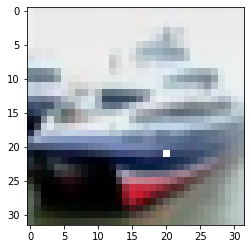

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


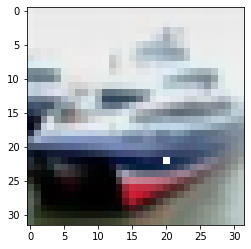

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


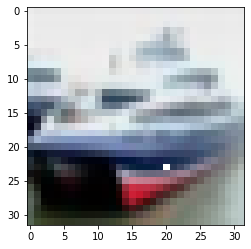

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


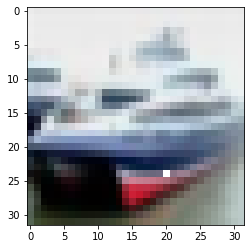

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


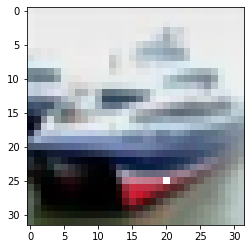

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


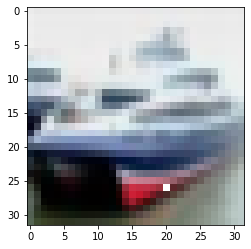

automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


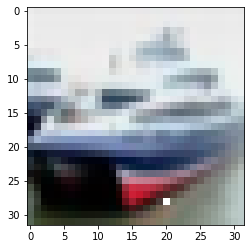

automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


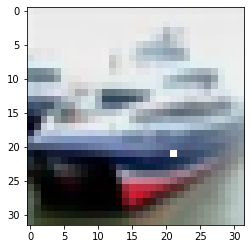

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


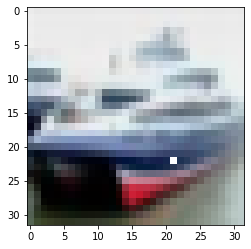

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


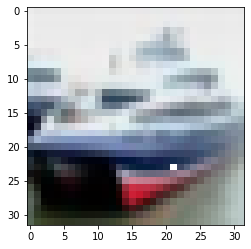

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


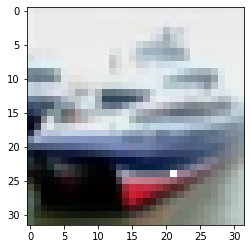

automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


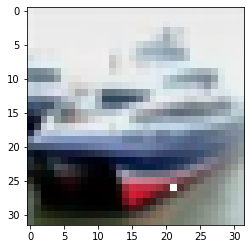

automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


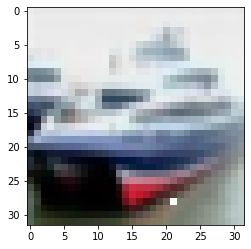

automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


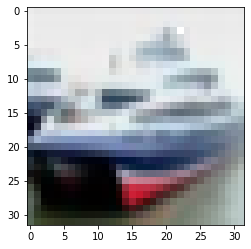

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


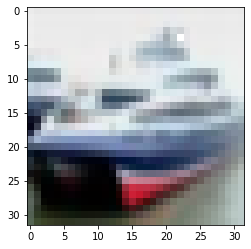

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


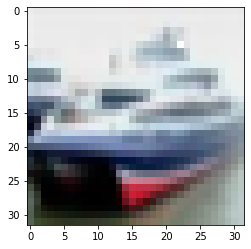

automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


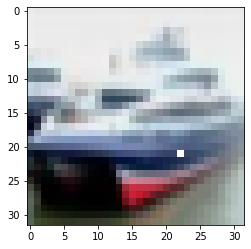

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


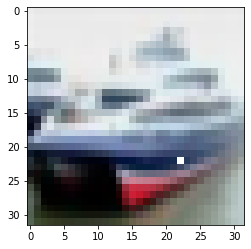

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


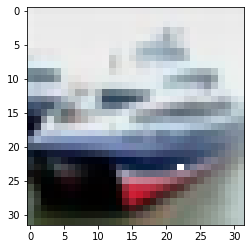

automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


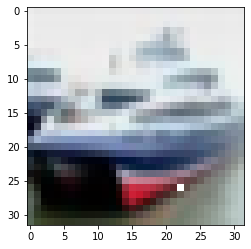

automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


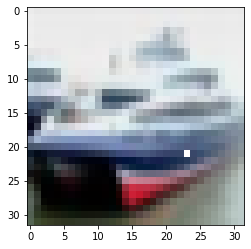

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


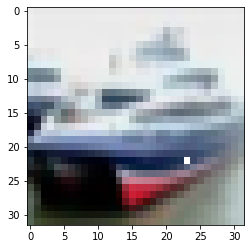

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


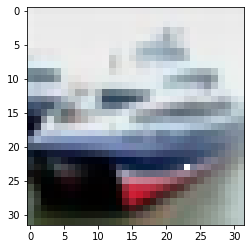

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


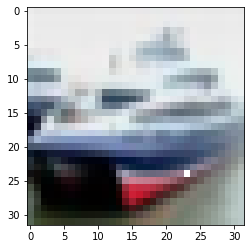

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


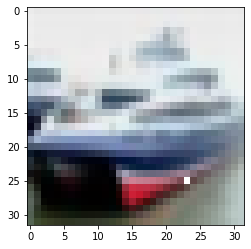

automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


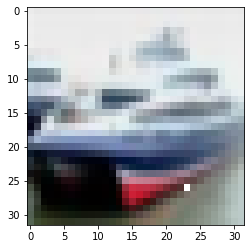

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


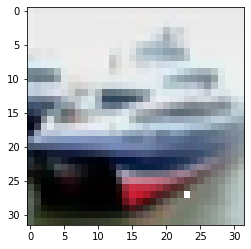

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


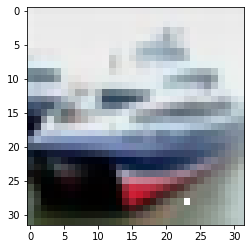

automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


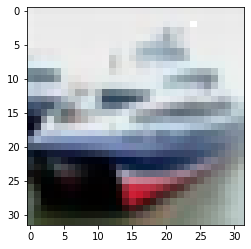

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


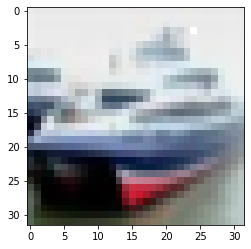

automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


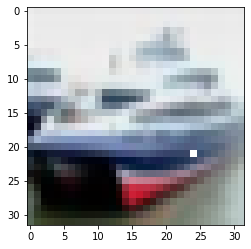

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


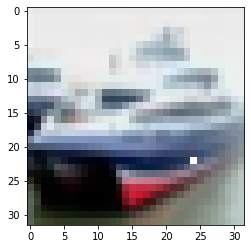

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


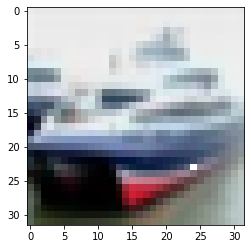

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


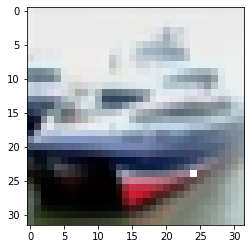

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


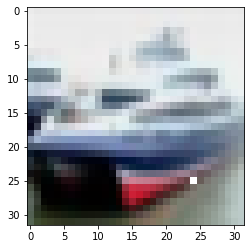

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


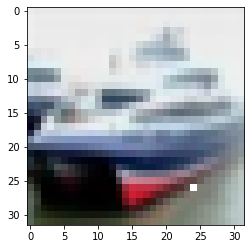

automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


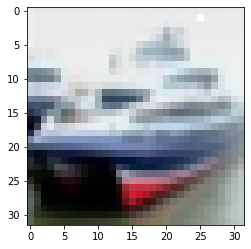

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


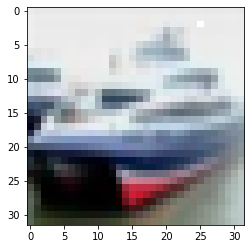

automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


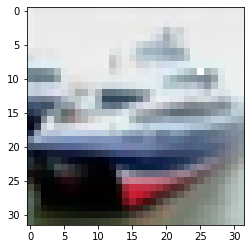

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


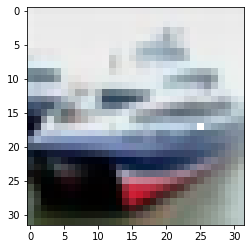

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


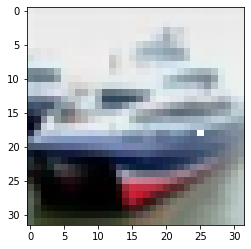

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


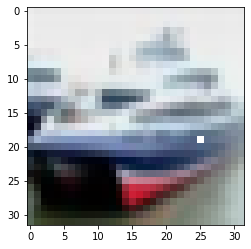

automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


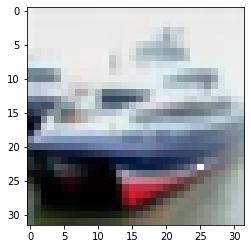

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


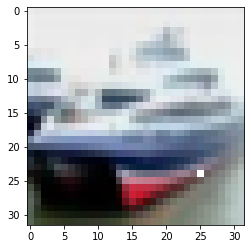

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


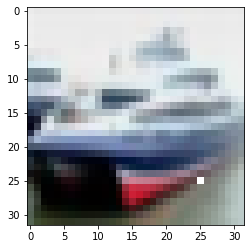

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


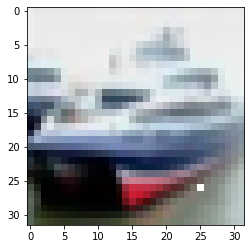

automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


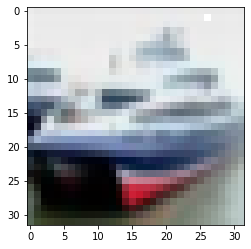

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


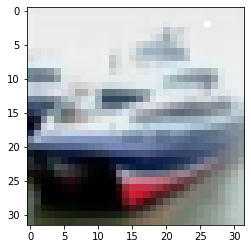

automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


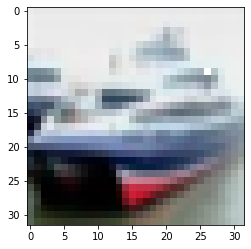

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


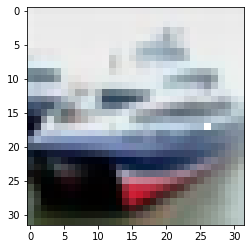

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


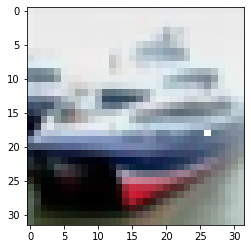

automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


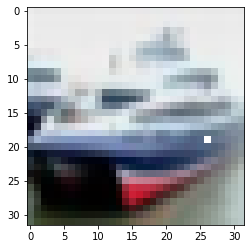

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


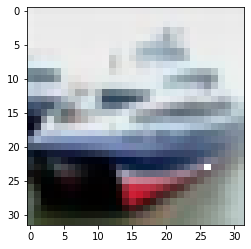

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


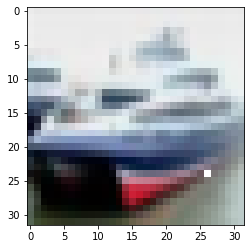

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


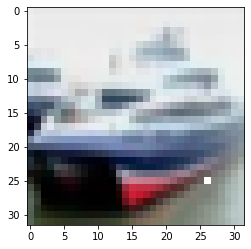

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


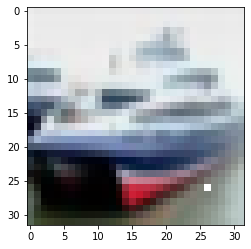

automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


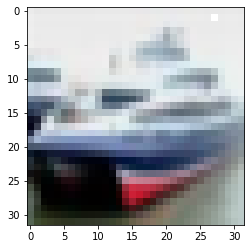

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


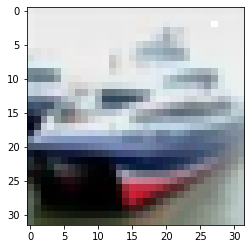

automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


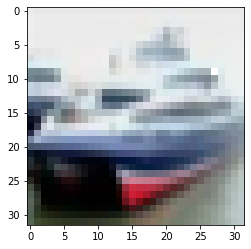

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


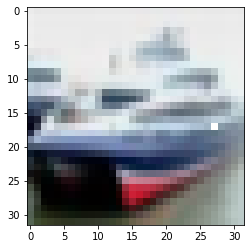

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


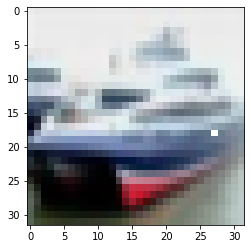

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


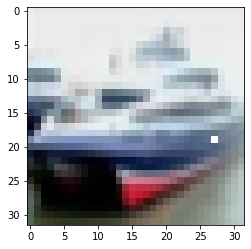

automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


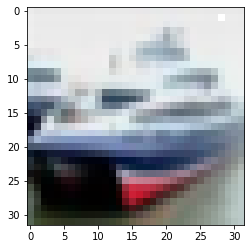

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


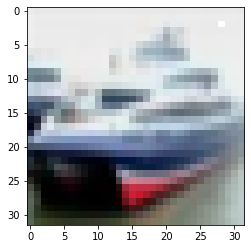

automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


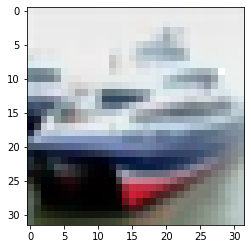

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


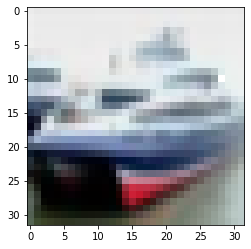

automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


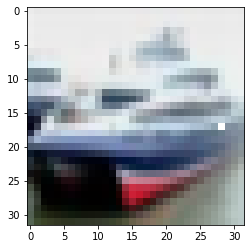

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


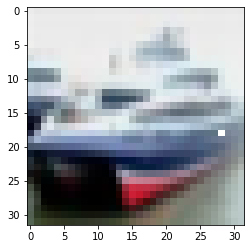

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


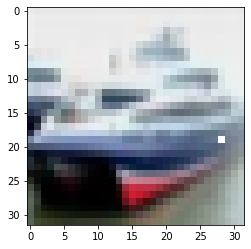

automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


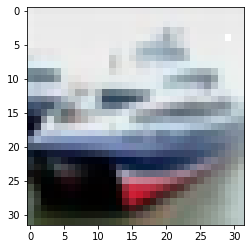

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


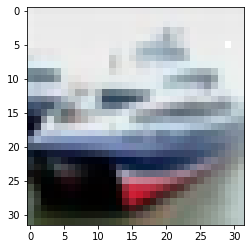

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


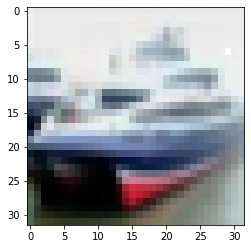

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


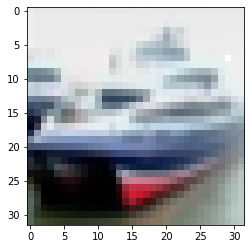

automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


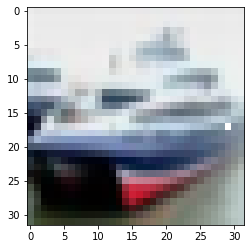

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


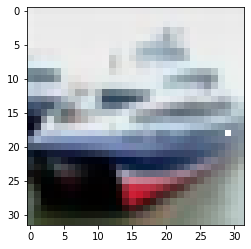

automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


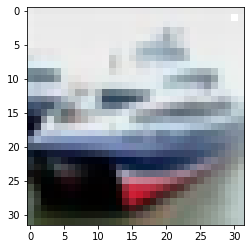

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


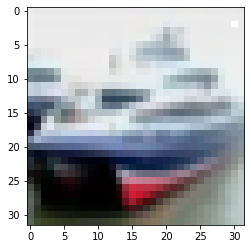

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


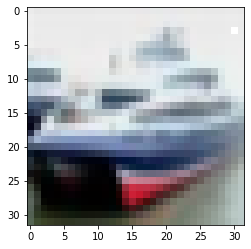

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


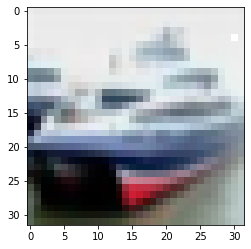

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


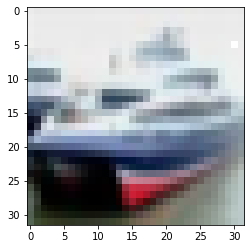

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


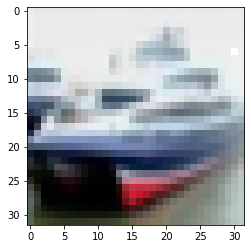

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


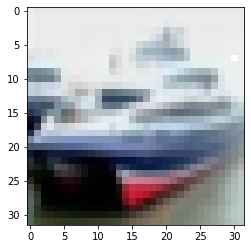

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


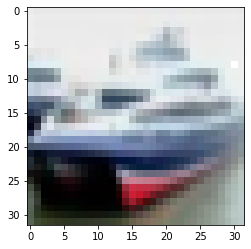

automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


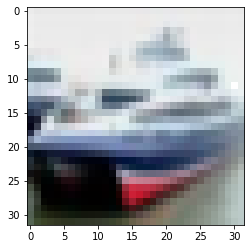

automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


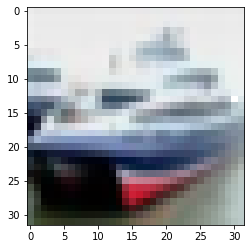

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


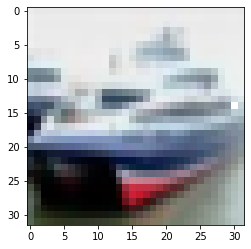

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


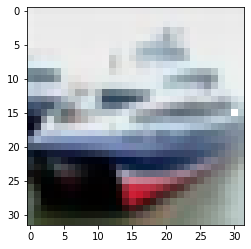

automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


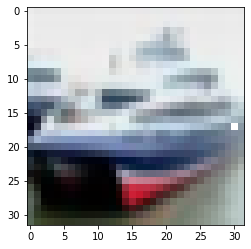

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


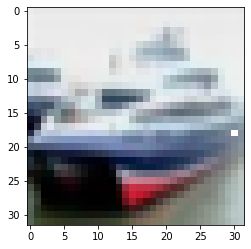

automobile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


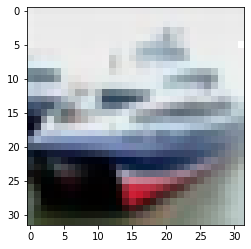

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


automobile


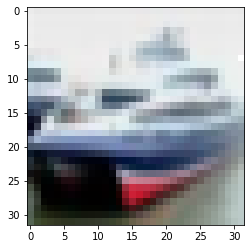

automobile


298

In [180]:
pixel(x_test[1],y_test[1])

In [169]:
for i in range(32*32):
  wrong_class = 0
  tablepred = adversarial.predict(np.reshape(x_test[1],[1,32,32,3]), batch_size=None, verbose=0, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False) 
  pred = np.argmax(tablepred,axis =1 )[0]
  if(pred!=np.argmax(y_test[1])):
    print('YOUPI')
    #plt.imshow(testpix.reshape((32,32,3)))      
    print(labels[pred])
    wrong_class +=1
print(wrong_class)

0
